In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
import random
import pandas as pd
from matplotlib import gridspec
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from datetime import datetime
import time
import corner
import emcee
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
from ltsfit.lts_linefit import lts_linefit

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [3]:
# df = pd.read_csv("edd_cf4_refined.csv", sep='|')
df = pd.read_csv("btfr_brent_updated.csv", sep='|')

for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df = df.rename(columns={"e_F21":"eF21"})

df = df.set_index("PGC")
print(df.columns)
print(len(df))

df.head()

Index(['flag', 'DM_av', 'eDM', 'DM_riz', 'eDM_riz', 'DM_W1', 'eDM_W1', 'DM_75',
       '1PGC', 'Nest', 'logMs_riz', 'logMs_W1', 'logM_gas', 'logMb', 'Vhel',
       'Vls', 'v3k', 'f', 'lgWmxi', 'elgWi', 'F21', 'eF21', 'inc', 'einc',
       'g***', 'r***', 'i***', 'z***', 'w1***', 'Qs', 'Qw', 'RA', 'DE',
       'GLong', 'GLat', 'SGL', 'SGB', 'Nkt', 'N15', 'SGLg', 'SGBg', 'Vhg',
       'Vlsg', 'V3kg', 'fg'],
      dtype='object')
10153


,flag,DM_av,eDM,DM_riz,eDM_riz,DM_W1,eDM_W1,DM_75,1PGC,Nest,...,SGL,SGB,Nkt,N15,SGLg,SGBg,Vhg,Vlsg,V3kg,fg
PGC,,,,,,,,,,,,,,,,,,,,,
2,1,34.57,0.45,NaN,NaN,34.57,0.28,34.11,73150,200275.0,...,341.6440,20.7388,0,7,341.4922,20.7395,5194,5486,4916,1.013
4,1,33.49,0.38,33.44,0.19,33.54,0.19,33.72,120,202766.0,...,316.0587,18.4514,0,0,316.0587,18.4514,4458,4706,4109,1.011
12,1,35.05,0.41,NaN,NaN,35.05,0.23,34.61,12,210177.0,...,286.4249,11.3511,0,1,286.4249,11.3510,6532,6669,6179,1.016
16,1,34.70,0.43,34.66,0.26,34.74,0.25,34.30,16,211419.0,...,287.6119,11.7030,0,1,287.6120,11.7030,5709,5851,5354,1.014
55,1,33.71,0.43,33.70,0.26,33.71,0.25,33.89,55,NaN,...,327.0996,19.7763,0,0,327.0996,19.7763,4779,5052,4454,1.012


In [4]:
df['Vmod'] = df.fg*df.Vlsg   # df.f*df.v3k # 
df['D75'] = df.Vmod / 75.
df['logD75'] = np.log10(df.D75)
df['DM_75'] = 5*df.logD75 + 25 
df['Mg_75'] = df['g***'] - df.DM_75
df['Mr_75'] = df['r***'] - df.DM_75
df['Mi_75'] = df['i***'] - df.DM_75
df['Mz_75'] = df['z***'] - df.DM_75
df['M1_75'] = np.asarray([np.float64(x) for x in df['w1***'].values]) - df.DM_75.values

df['gi'] = df['g***'] - df['i***']

/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
df_alfa = pd.read_csv("ALFALFA.csv", sep='|')
for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df_alfa = df_alfa.set_index("PGC")
df_alfa = df_alfa[["F", "e_F"]]
df_alfa.head()

,F,e_F
PGC,,
4,1.96,0.07
6,1.13,0.09
10,2.47,0.06
20,2.30,0.11
28,2.49,0.11


In [6]:
df_adhi = pd.read_csv("ADHI.csv", sep='|')
for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)
df_adhi = df_adhi.set_index("PGC")
df_adhi = df_adhi[["Flux"]]

df_adhi.head()

,Flux
PGC,
2,4.73
4,1.85
6,NaN
10,2.47
12,3.40


In [7]:
df = df.join(df_alfa, how='left')
df = df.join(df_adhi, how='left')

df = df.rename(columns={"Vls":"V3k"})

df.head()

,flag,DM_av,eDM,DM_riz,eDM_riz,DM_W1,eDM_W1,DM_75,1PGC,Nest,...,logD75,Mg_75,Mr_75,Mi_75,Mz_75,M1_75,gi,F,e_F,Flux
PGC,,,,,,,,,,,,,,,,,,,,,
2,1,34.57,0.45,NaN,NaN,34.57,0.28,34.349020,73150,200275.0,...,1.869804,NaN,NaN,NaN,NaN,-22.459020,NaN,NaN,NaN,4.73
4,1,33.49,0.38,33.44,0.19,33.54,0.19,34.011709,120,202766.0,...,1.802342,-18.421709,-18.681709,-18.891709,-18.941709,-17.941709,0.47,1.96,0.07,1.85
12,1,35.05,0.41,NaN,NaN,35.05,0.23,34.779466,12,210177.0,...,1.955893,NaN,NaN,NaN,NaN,-21.189466,NaN,NaN,NaN,3.40
16,1,34.70,0.43,34.66,0.26,34.74,0.25,34.491034,16,211419.0,...,1.898207,-20.131034,-20.631034,-20.911034,-21.091034,-20.501034,0.78,NaN,NaN,1.19
55,1,33.71,0.43,33.70,0.26,33.71,0.25,34.167913,55,NaN,...,1.833583,-18.637913,-18.847913,-18.947913,-18.997913,-17.967913,0.31,NaN,NaN,4.30


In [8]:
df['F21_av'] = df[["F", "Flux"]].mean(axis=1)

dg = df[["F21", "eF21", "F", "e_F", "Flux", "F21_av"]]
dg['F21_'] = dg.apply(lambda X: X.F21_av if ~np.isnan(X.F21_av) else X.F21, axis=1)
dg['F21_e'] = dg.apply(lambda X: X.e_F if ~np.isnan(X.F) else X.eF21, axis=1)


adhi_list = [5072, 9670, 49734, 51401, 1737674, 3091777, 5807477]
dg.loc[adhi_list]['F21_'] = dg.loc[adhi_list].Flux   # using ADHI HI flux values


len(dg)

# df["F21"] = dg.F21_
# df["eF21"] = dg.F21_e

<ipython-input-8-69eae98da3b9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dg['F21_'] = dg.apply(lambda X: X.F21_av if ~np.isnan(X.F21_av) else X.F21, axis=1)
<ipython-input-8-69eae98da3b9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dg['F21_e'] = dg.apply(lambda X: X.e_F if ~np.isnan(X.F) else X.eF21, axis=1)


10153

In [9]:
new_drop = pd.read_csv("drop_january2021.bar", sep='|')

df = df.drop(new_drop.PGC.values, errors='ignore')

len(df)

10153

In [10]:
calib = pd.read_csv("../calibrators/allzpa_labels.csv", sep=',')

for col in calib.columns:
    newcol = col.strip()
    calib.rename(columns={col:newcol}, inplace=True)
    
calib_weird = [68535, 28378, 42081, 39461, 44536]
calib['Name']=calib.apply(lambda x: None if x.PGC in calib_weird else x.Name, axis=1)
            
calib.set_index('PGC', inplace=True)

calib = calib.join(df[["V3k", "Vmod", "Qs", "Qw", "F21", 'eF21', 'elgWi', 'g***', 'r***', 'i***', 'z***']]).dropna()
calib = calib[(calib.Qs>2) & (calib['i']>0)]

calib['Dist'] = 10**((calib.dm19-25)/5.)
calib['Mass_HI'] = 2.356E5 * calib.F21 * (calib.Dist**2)


for waveband in ['g***','r***','i***','z***']:
    calib[waveband] = calib.apply(lambda x: x[waveband] if x[waveband]!=0 else np.nan, axis=1)
for waveband in ['g','r','i','z']:
    calib[waveband+'***'] = calib.apply(lambda x: x[waveband+'***'] if x[waveband]!=0 else np.nan, axis=1)

calib['Mr'] = calib['r***']-calib.dm19
calib['Mi'] = calib['i***']-calib.dm19
calib['Mz'] = calib['z***']-calib.dm19
calib['gi'] = calib["g***"]-calib['i***']


calib['logMs_i']  = 1.619 + 0.510*calib.gi - 0.4*calib['Mi']
calib['logMs_r']  = 1.617 + 0.650*calib.gi - 0.4*calib['Mr']
calib['logMs_z']  = 1.610 + 0.461*calib.gi - 0.4*calib['Mz']


alfa = 0.536
beta = 1.616
calib['logMs_riz'] = beta + alfa*calib.gi - 0.4*calib.Mi

calib['Ms_riz'] = 10**calib.logMs_riz
calib = calib.dropna()

print(len(calib))
calib.head()

45


,So,Name,dm19,inc,lgWmxi,eWi,Mu,Mg,Mr,Mi,...,i***,z***,Dist,Mass_HI,gi,logMs_i,logMs_r,logMs_z,logMs_riz,Ms_riz
PGC,,,,,,,,,,,,,,,,,,,,,
21396,2,NGC2403,27.514,58,2.454,0.026,-18.56,-19.43,-19.704,-19.854,...,7.66,7.64,3.182731,3.273213e+09,0.42,9.7748,9.7716,9.75322,9.78272,6.063453e+09
28357,2,NGC3021,32.327,58,2.454,0.022,-19.11,-20.11,-20.617,-20.897,...,11.43,11.30,29.201153,2.535331e+09,0.79,10.3807,10.3773,10.38499,10.39824,2.501727e+10
32192,2,NGC3368,30.165,52,2.630,0.024,-19.29,-20.67,-21.355,-21.715,...,8.45,8.31,10.789467,2.248998e+09,1.04,10.8354,10.8350,10.83144,10.85944,7.235024e+10
32207,2,NGC3370,32.149,56,2.514,0.021,-19.43,-20.22,-20.589,-20.779,...,11.37,11.30,26.902956,4.424994e+09,0.56,10.2162,10.2166,10.20776,10.22776,1.689507e+10
34695,2,NGC3627,30.125,64,2.605,0.015,-20.04,-21.16,-21.715,-21.985,...,8.14,7.99,10.592537,1.206747e+09,0.82,10.8312,10.8360,10.84202,10.84952,7.071638e+10


In [11]:
# calib.loc[26317].head(20)

In [12]:
def linear(x, m, b):
    return m*x+b

def linear_m(x, m):
    return m*x

In [13]:
gamma = np.log10(0.5) + 0.4*5.91
df['logMs_W1'] = gamma - 0.4*df['M1_75']
df['Ms_W1'] = 10**df.logMs_W1

df['Mass_HI'] = 2.356E5 * df.F21 * (df.D75**2)

df['logMs_i']  = 1.619 + 0.510*df.gi - 0.4*df['Mi_75']
df['logMs_r']  = 1.617 + 0.650*df.gi - 0.4*df['Mr_75']
df['logMs_z']  = 1.610 + 0.461*df.gi - 0.4*df['Mz_75']

alfa = 0.510
beta = 1.619
df['logMs_riz'] = beta + alfa*df.gi - 0.4*df.Mi_75
df['Ms_riz'] = 10**df.logMs_riz

In [14]:
mc = -5.967700322195351e-05
def HI_corrector(mc, bc, V3k):
    return 0 # mc*V3k+bc

/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


iter:  0
iter:  1
3.141549843952685 10.4911464931444


<ipython-input-15-e8149be534ee>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = 0.
<ipython-input-15-e8149be534ee>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = m0*(dff.lgWmxi-2.5)+b0 - dff.logMb
<ipython-input-15-e8149be534ee>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

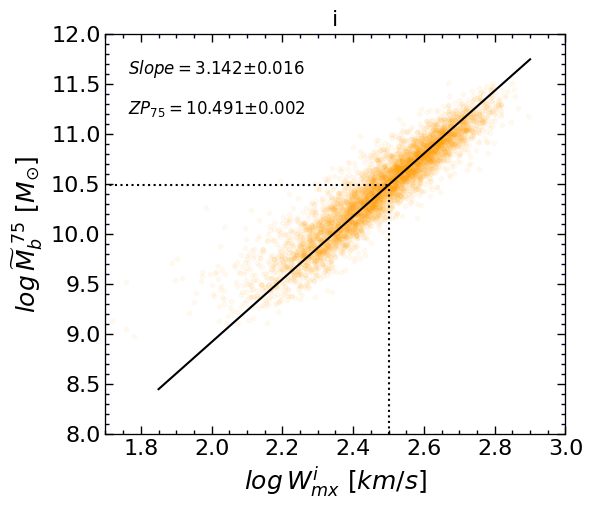

In [15]:
df['Mb'] = df.Ms_riz + 1.33*(10**(np.log10(df.Mass_HI)+HI_corrector(mc, 0, df.V3k.values)))
df['logMb'] = np.log10(df.Mb.values)

dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
std = 1.E10
dff['delta'] = 0.

for jj in range(2):
    
    dff = dff[np.abs(dff.delta)<3.5*std]

    logW = dff.lgWmxi.values
    logWe = dff.elgWi.values
    logMass = dff.logMb.values
    V3k = dff.V3k.values

    ln10 = np.log(10)
    dMs = 0.4*0.05*ln10
    dM21 = 2.356E5 * dff.eF21.values * (dff.D75.values**2)
    dMb = np.sqrt(dMs**2+(1.33**2)*dM21**2)
    Mb = dff.Ms_riz.values + 1.33*(10**(np.log10(dff.Mass_HI.values)))
    dlogMb = dMb/Mb/ln10


    fit, cov = curve_fit(linear, logMass, logW-2.5, sigma=np.sqrt(logWe**2+(0.01)**2))
    m, b = fit[0], fit[1]
    me = np.sqrt(cov[0,0])
    be = np.sqrt(cov[1,1])
    mbe = cov[1,0]    
    m0 = 1./m
    b0 = -b/m
    dm0 = np.abs(me/m**2)
    db0 = np.sqrt((b0**2 )*(be**2/b**2+me**2/m**2-2*mbe/m/b))
    
    
    fit, cov = np.polyfit(logW-2.5, logMass, 1, w=1./(m*logWe), cov=True)
    m = fit[0]
    b = fit[1]
    
#     if jj>0:
#         mcfit = lts_linefit(logW-2.5, logMass, np.sqrt(logWe**2+(0.01)**2), 0.*dlogMb+0.01, clip=3.)    

    dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
    dff['delta'] = m0*(dff.lgWmxi-2.5)+b0 - dff.logMb
    std = dff['delta'].std()
    
    print("iter: ", jj)

    
logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

##################################################################

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values
ax.plot(logW, logMass, '.', color='orange', alpha=0.05) 


w = np.linspace(1.85,2.9,100)
ax.plot(w, m0*(w-2.5) + b0, 'k-')
print(m0,b0)    
        
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ \widetilde{M}_b^{\/\/75} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (8,12))

ax.set_title("i", fontsize=16)

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.95*Xlm[0]+0.05*Xlm[1]
y0 = 0.1*Ylm[0]+0.9*Ylm[1]
ax.text(x0,y0, r"$Slope = $"+"%.3f" % m0+'$\pm$'+"%.3f" % dm0, fontsize=12, color='k')
y0 = 0.2*Ylm[0]+0.8*Ylm[1]
ax.text(x0,y0, r"$ZP_{75} = $"+"%.3f" % b0+'$\pm$'+"%.3f" % db0, fontsize=12, color='k')

ax.plot([2.5,2.5], [8, b0], 'k:')
ax.plot([0,2.5], [b0, b0], 'k:')

3.141549843952685 10.4911464931444


/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-16-dd4d219e7ce4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = 0.


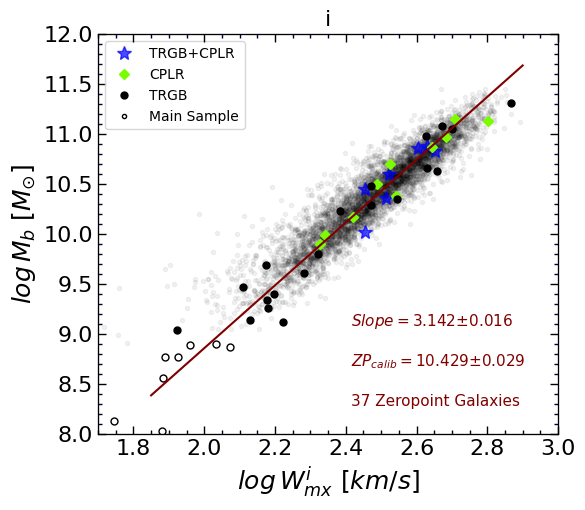

In [16]:
df['Mb'] = df.Ms_riz + 1.33*(10**(np.log10(df.Mass_HI)+HI_corrector(mc, 0, df.V3k.values)))
df['logMb'] = np.log10(df.Mb.values)

calib['Mb'] = calib.Ms_riz + 1.33*(10**(np.log10(calib.Mass_HI)+HI_corrector(mc, 0, calib.V3k.values)))
calib['logMb'] = np.log10(calib.Mb.values)


dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
std = 1.E10
dff['delta'] = 0.

  
logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

##################################################################
def linear_zp(x, zp):
    
    return x/m0+zp

X = calib.lgWmxi.values
Xe = calib.elgWi.values
Y = calib.logMb.values
BB = calib['logMb']
So = calib.So.values

fit, cov = curve_fit(linear_zp, Y[BB>9], X[BB>9]-2.5, sigma=np.sqrt(Xe[BB>9]**2+(0.01)**2))
zp_calib = -fit[0]*m0
zp_calib_e = np.sqrt(cov[0][0])*m0

zp_calib_e = np.sqrt(zp_calib_e**2+db0**2)

zp_calib += 0.0320


logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values
ax.plot(logW, logMass-b0+zp_calib, '.', color='k', alpha=0.05) 

ind, = np.where((BB<9)&(So==2))
ax.plot(X[ind], Y[ind], '*', ms=10, color='blue', mfc='white') 
ind, = np.where((BB>9)&(So==2))
ax.plot(X[ind], Y[ind], '*', ms=10, color='blue', alpha=0.7, label='TRGB+CPLR') 


ind, = np.where((BB<9)&(So==0))
ax.plot(X[ind], Y[ind], 'D', ms=5, color='lawngreen', mfc='white') 
ind, = np.where((BB>9)&(So==0))
ax.plot(X[ind], Y[ind], 'D', ms=5, color='lawngreen', alpha=1.0, label='CPLR') 


ind, = np.where((BB<9)&(So==1))
ax.plot(X[ind], Y[ind], 'o', ms=5, color='k', mfc='white') 
ind, = np.where((BB>9)&(So==1))
ax.plot(X[ind], Y[ind], 'o', ms=5, color='k', label='TRGB') 

ax.plot([0], [0], '.', color='k', label='Main Sample', mfc='white') 
#######################################################################

w = np.linspace(1.85,2.9,100)
ax.plot(w, m0*(w-2.5) + zp_calib, '-', color='maroon')
print(m0,b0)    

    
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$log \/ \widetilde{M}_b \/\/ [M_{\odot}]$', fontsize=18)
ax.set_ylabel(r'$log \/ M_b \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (8,12))

ax.set_title("i", fontsize=16)

# Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
# x0 = 0.95*Xlm[0]+0.05*Xlm[1]
# y0 = 0.1*Ylm[0]+0.9*Ylm[1]
# ax.text(x0,y0, r"$Slope = $"+"%.3f" % m0+'$\pm$'+"%.3f" % dm0, fontsize=12, color='k')
# y0 = 0.2*Ylm[0]+0.8*Ylm[1]
# ax.text(x0,y0, r"$ZP_{75} = $"+"%.3f" % b0+'$\pm$'+"%.3f" % db0, fontsize=12, color='k')


Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.45*Xlm[0]+0.55*Xlm[1]
y0 = 0.93*Ylm[0]+0.07*Ylm[1]
ax.text(x0,y0, "%d"%len(Xe[BB>9])+' Zeropoint Galaxies', fontsize=11, color='maroon')
y0 = 0.83*Ylm[0]+0.17*Ylm[1]
ax.text(x0,y0, r"$ZP_{calib} = $"+"%.3f" % zp_calib+'$\pm$'+"%.3f" % zp_calib_e, fontsize=11, color='maroon')
y0 = 0.73*Ylm[0]+0.27*Ylm[1]
ax.text(x0,y0, r"$Slope = $"+"%.3f" % m0+'$\pm$'+"%.3f" % dm0, fontsize=11, color='maroon')

ax.legend(loc=2)

In [17]:
np.std(Y[(Y<11.5)&(Y>9.0)] - (m0*(X[(Y<11.5)&(Y>9.0)]-2.5) + zp_calib))

0.18086485828020527

In [18]:
std

10000000000.0

In [19]:
b0 = zp_calib
b0

10.429458857354692

/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-20-85d3970b3e1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = 0.


718
758
53


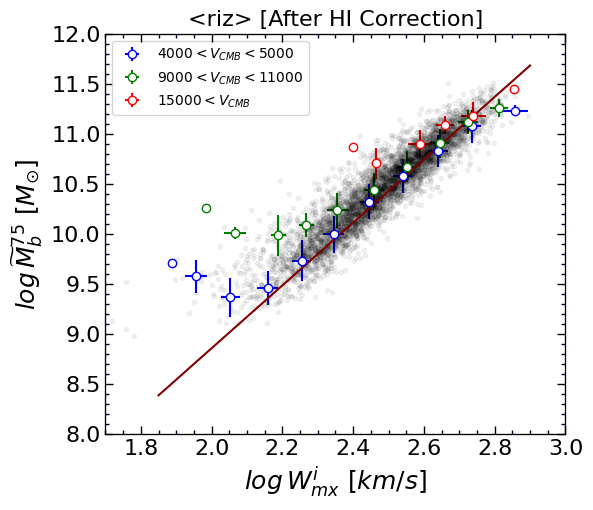

In [20]:
df['Mb'] = df.Ms_riz + 1.33*(10**(np.log10(df.Mass_HI)+HI_corrector(mc, 0, df.V3k.values)))
df['logMb'] = np.log10(df.Mb.values)

dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
std = 1.E10
dff['delta'] = 0.
    

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

ax.plot(logW, logMass, 'k.', alpha=0.05) 

X0 = logW
Y0 = logMass
V3k = dff.V3k.values
label=r'$4000<V_{CMB}<5000$'
ind, = np.where((V3k>4000)&(V3k<5000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='blue', ms=6, mfc='white', label=labe)       
        
        
label=r'$9000<V_{CMB}<11000$'
ind, = np.where((V3k>9000)&(V3k<11000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='green', ms=6, mfc='white', label=labe)      
   

        
label=r'$15000<V_{CMB}$'
ind, = np.where((V3k>15000)&(V3k<20000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6, mfc='white', label=labe)   
    
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ \widetilde{M}_b^{75} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (8,12))

ax.set_title("<riz> [After HI Correction]", fontsize=16)

ax.legend()

ax.plot(w, m0*(w-2.5) + b0, '-', color='maroon')

In [21]:
m0, b0, alfa, beta, mc

(3.141549843952685, 10.429458857354692, 0.51, 1.619, -5.967700322195351e-05)

In [22]:
def getDM(mag_r, mag_i, mag_z, Wlog, F21, m0, b0, D, gi, V3k):
    
    Mb = 10**(m0*(Wlog-2.5)+b0)
    
    M21 = 2.356E5 * F21 * (D**2)
    M21 = 10**(np.log10(M21) + HI_corrector(mc, 0, V3k))
        
    alfa = 0.510
    beta = 1.619
    logXriz = beta + alfa*gi
    
    Mag_riz = -2.5*(np.log10(Mb - 1.33*M21) - logXriz)
    
    if mag_i>0 :
        DM = mag_i - Mag_riz
    else:
        return np.nan

    
    D = 10**((DM-25)/5)
    
    return D


def interpol(X, Y):
    
    X0 = X[~np.isnan(Y)]
    Y0 = Y[~np.isnan(Y)]
      
    N = len(X0)
    
    for i in range(N-1):
        
        if Y0[i]<0 and Y0[i+1]>0:
            break

    return -Y0[i]*(X0[i+1]-X0[i])/(Y0[i+1]-Y0[i])+X0[i]

In [23]:
b0

10.429458857354692

In [24]:
def getDM_simul(D, mag, gi, Wlog, F21, alfa, beta, MtoLscatter, slope, zp, V3k, mc):
    
    Mb = 10**(slope*(Wlog-2.5)+zp)
    
    M21 = 2.356E5 * F21 * (D**2)
    M21 = 10**(np.log10(M21) + mc*V3k)
    
    logX = beta + alfa*gi + MtoLscatter
    Mag  = -2.5*(np.log10(Mb - 1.33*M21) - logX)
       
    DM = mag - Mag
    D = 10**((DM-25)/5)
    
    return D


npzName = "MLratio_i_gi.npz"
npzfile = np.load(npzName)
samples_ = npzfile['arr_0']
samples_ = samples_[np.where(samples_[:,0]>0.48)]
samples_ = samples_[(samples_[:,1]>1.56)&(samples_[:,1]<1.68)]
samples_ = samples_[np.where(samples_[:,3]>10.31)]

alfaPool = samples_[:,0]
betaPool = samples_[:,1]
slopePool = samples_[:,2]
meanZP = np.mean(samples_[:,3])
zpPool = samples_[:,3]-meanZP+b0

n, m = samples_.shape

Nsimul = 300

In [25]:
t1 =  datetime.now()
print(t1)

dff = df[(df.Qs>0)&(df.elgWi>0)&(df.lgWmxi>0)]
Wlog = dff.lgWmxi.values
eWlog = dff.elgWi.values
F21 = dff.F21.values
eF21 = dff.eF21.values
D75 = dff.D75.values
gi = dff.gi.values
V3k = dff.V3k.values
PGC = dff.index.values
mag_r = dff["r***"].values
mag_i = dff["i***"].values
mag_z = dff["z***"].values


N = len(dff)
DM_fid = np.zeros(N) + np.nan
eDM_fid = np.zeros(N) + np.nan
DMav_fid = np.zeros(N) + np.nan
print(N)
pp=0


for j in range(N): # range(50): #
    
    if mag_r[j]>0 and mag_i[j]>0 and mag_z[j]>0:
        D = np.arange(0.5,800,0.5)

        delta =  D - getDM(mag_r[j], mag_i[j], mag_z[j], Wlog[j], F21[j], m0, b0, D, gi[j], V3k[j])

        D = D[~np.isnan(delta)]
        delta = delta[~np.isnan(delta)]

        try:
            D_root = interpol(D, delta)
            DM_fid[j] = 5*np.log10(D_root)+25
        except:
            D_root = np.max(D[delta<0])
            DM_fid[j] = 5*np.log10(D_root)+25
            print("flag (j, pgc): ", j, PGC[j])
            pp+=1
        if j%1000==0:
            print(j, datetime.now())
    else:
        print("flag (j, pgc, nan): ", j, PGC[j])
        D_root = np.nan
        
    ## uncertainty calucaltion unit
    try:
        DMsimuls = np.zeros(Nsimul) + np.nan
        for i in range(Nsimul):
            try:

                jj = np.random.randint(n)
                D = np.arange(0.5,800,0.5)
                delta = D - getDM_simul(D, \
                                  np.random.normal(mag_i[j], 0.07), \
                                  np.random.normal(gi[j], 0.1), \
                                  np.random.normal(Wlog[j], eWlog[j]), \
                                  np.random.normal(F21[j], eF21[j]), \
                                  alfaPool[jj], betaPool[jj], \
                                  np.random.normal(0, 0.07), \
                                  slopePool[jj], np.random.normal(zpPool[jj], 0.04), \
                                  V3k[j], \
                                  np.random.normal(mc, 7.03018543e-07))
                D = D[~np.isnan(delta)]
                delta = delta[~np.isnan(delta)]
                try:
                    D0 = interpol(D, delta)
                    DMsimuls[i] = 5*np.log10(D0)+25
                except:
                    D0 = np.max(D[delta<0])
                    DMsimuls[i] = 5*np.log10(D0)+25
            except:
                pass    
        

        eDM_fid[j]  = np.std(DMsimuls)
        DMav_fid[j] = np.mean(DMsimuls)
        
#         print("pgc, DM, DMav, eDM : ", j, PGC[j], "%.2f"%DM_fid[j], "%.2f"%DMav_fid[j], "%.2f"%eDM_fid[j])
#         print("   ", Wlog[j], eWlog[j], F21[j], eF21[j], V3k[j], gi[j])
    except:
        pass


print("Number of concerning distances:", pp)

###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

2021-08-11 18:19:27.099191
7096
0 2021-08-11 18:19:27.106934


<ipython-input-22-4d3b419b426e>:12: RuntimeWarning: invalid value encountered in log10
  Mag_riz = -2.5*(np.log10(Mb - 1.33*M21) - logXriz)
<ipython-input-24-6ef86fc570a4>:9: RuntimeWarning: invalid value encountered in log10
  Mag  = -2.5*(np.log10(Mb - 1.33*M21) - logX)
<ipython-input-24-6ef86fc570a4>:6: RuntimeWarning: invalid value encountered in log10
  M21 = 10**(np.log10(M21) + mc*V3k)


1000 2021-08-11 18:22:30.451279
flag (j, pgc, nan):  1317 23362
flag (j, pgc, nan):  1549 26317


<ipython-input-22-4d3b419b426e>:6: RuntimeWarning: divide by zero encountered in log10
  M21 = 10**(np.log10(M21) + HI_corrector(mc, 0, V3k))


flag (j, pgc, nan):  1756 28630
2000 2021-08-11 18:25:56.339323
flag (j, pgc, nan):  2966 42089
3000 2021-08-11 18:29:14.696836
flag (j, pgc, nan):  3702 51664
4000 2021-08-11 18:32:50.266815
flag (j, pgc, nan):  4261 57627
5000 2021-08-11 18:36:39.486102
6000 2021-08-11 18:40:28.239102
7000 2021-08-11 18:43:46.940660
Number of concerning distances: 0
Execution time:
0:24:36.008615


In [26]:
mag_r[j], mag_i[j], mag_z[j]

(14.38, 14.17, 14.1)

In [27]:
for j in range(N):
    
    if np.abs(DM_fid[j]-DMav_fid[j]) > 0.1:
        print(PGC[j], "%.2f"%DM_fid[j], "%.2f"%DMav_fid[j], "%.2f"%eDM_fid[j])

16 34.63 34.73 0.31
55 33.53 33.86 0.24
68 34.73 34.92 0.42
70 35.03 35.41 0.21
76 34.60 34.79 0.27
92 32.74 32.93 0.23
96 36.23 36.62 0.26
102 34.19 34.35 0.24
124 34.26 34.60 0.20
128 35.49 36.21 0.29
146 34.12 34.24 0.32
165 34.66 34.97 0.22
176 34.97 35.15 0.33
186 35.02 35.33 0.27
201 35.10 35.27 0.39
205 34.85 35.12 0.29
212 36.12 36.48 0.26
216 33.95 34.15 0.29
218 31.58 31.72 0.25
222 35.02 35.58 0.22
247 36.83 37.13 0.37
250 34.15 34.40 0.32
257 34.82 35.30 0.19
258 35.84 36.16 0.25
259 34.60 34.78 0.30
279 32.31 32.42 0.26
298 33.57 33.79 0.27
301 34.09 34.24 0.21
303 33.45 33.64 0.31
305 32.81 32.95 0.23
312 33.21 33.33 0.32
329 33.96 34.34 0.25
345 34.09 34.63 0.37
354 34.63 34.84 0.32
366 34.66 34.85 0.38
415 34.94 35.10 0.29
431 34.37 34.71 0.20
451 34.03 34.18 0.23
465 35.76 35.95 0.32
496 30.68 30.38 0.25
507 34.89 35.10 0.26
559 34.11 34.38 0.20
567 35.09 35.31 0.28
569 34.34 34.52 0.25
613 34.64 34.81 0.30
616 35.76 36.06 0.31
619 32.75 32.87 0.29
642 34.52 34.67 0.30

5916 34.32 34.62 0.33
5945 34.03 34.27 0.22
5986 34.90 35.19 0.28
6006 34.63 34.87 0.44
6074 35.73 36.08 0.24
6108 34.56 34.72 0.36
6137 34.64 34.75 0.42
6169 34.71 34.92 0.32
6193 35.31 35.83 0.21
6209 35.45 35.75 0.39
6228 31.51 31.41 0.27
6246 34.90 35.14 0.25
6263 34.06 34.34 0.22
6275 32.85 33.02 0.25
6292 29.96 29.75 0.20
6294 32.22 32.34 0.17
6302 35.59 35.96 0.25
6309 31.09 30.93 0.29
6329 34.12 34.24 0.23
6332 33.74 33.97 0.25
6335 35.64 35.91 0.41
6377 35.35 35.74 0.27
6380 34.09 34.24 0.27
6434 35.89 36.18 0.29
6437 30.54 30.22 0.62
6459 34.90 35.23 0.30
6475 33.70 33.84 0.23
6485 34.21 34.35 0.31
6500 31.96 31.81 0.22
6546 34.40 34.54 0.24
6573 35.17 35.46 0.27
6574 28.70 28.48 0.19
6580 34.08 34.28 0.32
6586 35.96 36.39 0.30
6587 34.06 34.22 0.45
6636 34.27 34.37 0.25
6678 35.26 35.47 0.37
6690 32.96 33.12 0.25
6699 28.79 28.48 0.25
6728 33.38 33.49 0.33
6735 34.67 34.85 0.33
6750 32.13 32.02 0.34
6759 33.04 33.24 0.25
6814 33.99 34.12 0.26
6817 33.73 33.83 0.25
6837 33.93

22394 35.22 35.42 0.29
22401 35.13 35.29 0.32
22413 34.65 34.81 0.25
22419 35.52 35.84 0.26
22433 34.00 34.11 0.26
22443 35.29 35.53 0.27
22448 34.20 34.31 0.24
22506 34.10 34.25 0.25
22509 36.75 37.19 0.25
22542 35.45 35.70 0.24
22565 33.98 34.15 0.28
22596 34.04 34.16 0.35
22606 36.10 36.46 0.61
22611 34.17 34.33 0.27
22618 34.17 34.30 0.34
22640 32.39 32.28 0.40
22646 35.61 35.89 0.43
22655 33.56 33.82 0.21
22689 34.98 35.16 0.32
22693 34.30 34.44 0.24
22695 34.49 34.66 0.34
22698 34.89 35.07 0.29
22706 35.00 35.17 0.34
22722 35.03 35.39 0.28
22733 35.67 35.93 0.33
22751 31.08 30.88 0.51
22752 34.81 34.95 0.35
22758 34.11 34.32 0.29
22778 34.19 34.41 0.26
22796 35.61 35.86 0.27
22802 35.09 35.39 0.33
22835 35.47 35.76 0.26
22873 33.64 33.75 0.16
22896 34.78 34.99 0.30
22909 34.58 34.87 0.28
22921 33.30 33.58 0.17
22965 34.41 34.71 0.24
22994 35.77 36.01 0.30
23014 33.57 33.80 0.34
23017 34.53 34.70 0.31
23018 34.51 34.66 0.32
23033 35.11 35.50 0.20
23046 34.26 34.37 0.21
23058 35.34

32845 35.36 35.76 0.21
32870 32.29 32.10 0.54
32871 35.14 35.62 0.23
32907 34.26 34.69 0.22
32922 35.35 35.56 0.32
33010 30.51 30.12 0.62
33012 35.46 35.77 0.29
33019 34.39 34.70 0.24
33041 34.59 34.77 0.23
33054 35.48 35.75 0.26
33058 36.20 36.67 0.23
33101 34.73 34.96 0.29
33147 34.80 34.93 0.24
33148 35.78 35.96 0.35
33174 35.50 35.83 0.29
33175 35.64 35.96 0.30
33190 35.54 35.91 0.27
33195 35.31 35.53 0.27
33208 31.82 31.63 0.21
33238 35.98 36.29 0.22
33249 35.24 35.48 0.26
33269 35.02 35.25 0.28
33270 32.20 32.06 0.27
33276 33.54 33.64 0.20
33278 35.48 35.81 0.41
33281 33.68 33.84 0.44
33294 34.60 34.77 0.30
33310 34.79 34.93 0.31
33322 35.61 35.83 0.45
33333 31.73 31.60 0.19
33388 34.72 34.98 0.29
33401 35.18 35.45 0.25
33447 28.66 28.10 0.50
33461 34.16 34.35 0.43
33463 33.57 33.73 0.38
33467 36.33 36.71 0.29
33480 34.69 34.97 0.35
33495 34.85 35.09 0.24
33496 35.38 35.58 0.27
33497 34.56 34.79 0.38
33523 30.44 30.11 0.37
33529 34.52 34.81 0.23
33549 35.81 36.12 0.24
33550 30.12

38684 33.19 33.07 0.60
38688 29.38 29.20 0.33
38709 35.30 35.59 0.23
38713 34.75 34.89 0.26
38755 34.44 34.72 0.28
38765 35.02 35.17 0.50
38784 33.50 33.40 0.26
38785 34.98 35.19 0.27
38795 31.13 31.24 0.26
38803 31.88 31.65 0.32
38834 34.59 34.78 0.35
38848 33.65 33.79 0.25
38851 33.13 33.28 0.28
38864 34.65 34.99 0.27
38868 35.21 35.32 0.44
38874 34.84 35.02 0.26
38897 30.50 30.40 0.19
38898 35.95 36.18 0.41
38919 35.49 35.74 0.25
38933 33.93 34.30 0.21
38945 31.01 30.73 0.22
38958 34.14 34.57 0.64
38961 34.76 35.13 0.21
38964 33.45 33.56 0.29
38977 35.08 35.54 0.19
38984 33.65 33.77 0.22
38989 34.71 35.08 0.49
38998 30.71 30.30 0.27
39009 32.30 32.12 0.64
39028 31.16 31.28 0.23
39038 36.12 36.55 0.29
39040 32.88 32.99 0.26
39046 34.46 34.72 0.20
39050 33.06 32.96 0.29
39051 34.95 35.12 0.25
39052 32.01 31.82 0.56
39099 34.66 34.91 0.23
39101 34.83 35.18 0.22
39113 31.82 31.59 0.20
39143 31.16 31.01 0.28
39177 35.90 36.23 0.25
39181 32.30 32.06 0.29
39191 30.71 30.48 0.42
39206 30.68

50609 34.88 35.25 0.26
50613 33.18 33.30 0.23
50621 35.12 35.36 0.26
50627 34.18 34.30 0.26
50630 34.65 34.91 0.27
50635 34.45 34.76 0.28
50648 34.71 34.99 0.25
50671 35.11 35.33 0.36
50696 35.10 35.30 0.31
50697 35.88 36.14 0.33
50713 33.69 34.13 0.18
50717 36.17 36.73 0.30
50720 35.41 35.69 0.28
50722 34.18 34.43 0.20
50752 35.81 36.26 0.28
50764 34.99 35.19 0.31
50784 34.45 34.78 0.27
50795 35.06 35.49 0.26
50807 31.21 31.11 0.42
50848 33.97 34.16 0.26
50853 33.04 33.20 0.21
50865 34.70 34.91 0.32
50866 34.07 34.17 0.33
50882 34.55 34.67 0.24
50889 34.04 34.22 0.26
50897 34.21 34.46 0.24
50910 34.19 34.37 0.32
50915 34.31 34.49 0.24
50930 35.32 35.58 0.24
50942 33.52 33.73 0.25
50972 35.35 35.72 0.22
50973 33.27 33.55 0.31
50976 35.62 36.01 0.24
50980 34.30 34.46 0.23
50994 35.26 35.76 0.31
50995 35.67 35.92 0.31
51002 33.99 34.15 0.20
51043 35.08 35.28 0.28
51047 35.10 35.27 0.31
51048 35.05 35.22 0.32
51065 35.19 35.71 0.28
51091 33.40 33.52 0.25
51100 35.89 36.28 0.29
51113 34.47

56992 35.33 35.74 0.47
56997 35.76 35.99 0.30
57012 35.85 36.02 0.36
57029 35.17 35.42 0.28
57037 35.77 36.08 0.31
57042 35.81 36.07 0.30
57061 35.55 36.13 0.23
57083 35.96 36.38 0.24
57091 35.73 36.16 0.27
57110 33.57 33.83 0.26
57122 35.83 36.02 0.32
57178 35.12 35.44 0.27
57181 33.74 33.89 0.17
57193 35.66 35.85 0.32
57208 34.58 34.71 0.32
57216 34.44 34.57 0.33
57218 34.60 34.88 0.39
57246 34.30 34.43 0.27
57250 35.50 35.72 0.31
57251 36.20 36.64 0.25
57273 35.89 36.15 0.33
57274 35.86 36.19 0.33
57278 35.67 35.93 0.29
57280 35.30 35.56 0.33
57284 35.72 36.05 0.27
57287 35.35 35.77 0.29
57293 35.40 35.69 0.27
57329 37.08 37.44 0.27
57337 35.29 35.73 0.26
57340 36.14 36.47 0.29
57349 35.70 35.99 0.30
57353 33.98 34.14 0.28
57356 33.42 33.65 0.19
57365 35.78 36.05 0.28
57369 35.51 35.82 0.25
57370 35.87 36.38 0.31
57373 34.57 34.77 0.28
57377 35.52 35.71 0.31
57390 35.08 35.43 0.28
57396 34.77 34.93 0.43
57407 33.57 33.71 0.27
57417 35.60 35.78 0.29
57430 35.09 35.29 0.29
57445 35.99

68872 34.87 35.05 0.29
68884 34.90 35.16 0.30
68894 34.67 34.80 0.23
68919 34.17 34.39 0.28
68942 33.35 33.46 0.29
68943 34.53 34.86 0.31
68946 35.05 35.26 0.25
68954 34.77 35.17 0.31
68963 35.65 35.91 0.36
68968 35.07 35.25 0.33
68985 34.57 34.86 0.23
68991 34.33 34.54 0.45
69016 34.62 34.84 0.27
69047 34.90 35.10 0.24
69072 34.24 34.67 0.22
69077 35.40 35.72 0.29
69089 35.80 36.17 0.32
69092 35.81 36.01 0.34
69095 35.29 35.51 0.35
69108 35.23 35.54 0.22
69148 35.57 35.84 0.30
69160 35.67 35.92 0.32
69172 33.98 34.18 0.28
69195 33.65 33.93 0.18
69198 35.94 36.27 0.36
69215 35.17 35.45 0.27
69224 30.37 30.14 0.43
69270 31.21 31.06 0.28
69284 34.97 35.20 0.26
69287 34.71 34.91 0.31
69299 35.69 36.11 0.24
69316 36.05 36.38 0.29
69325 35.41 35.65 0.36
69327 30.69 30.86 0.24
69336 36.56 37.01 0.27
69347 32.94 33.06 0.65
69351 34.26 34.57 0.25
69367 33.48 33.63 0.28
69372 36.49 36.80 0.31
69394 37.72 38.35 0.29
69402 34.88 35.01 0.31
69417 36.09 36.33 0.32
69428 34.85 35.11 0.23
69429 34.66

194349 35.67 36.16 0.69
200158 34.57 34.76 0.27
212675 36.33 36.80 0.34
212688 34.84 35.20 0.22
212696 34.73 34.85 0.43
212999 34.41 34.67 0.31
213532 33.46 33.68 0.19
213593 32.36 32.22 0.36
213663 33.22 33.45 0.19
213670 35.21 35.85 0.20
213686 34.57 34.83 0.21
213804 36.33 36.82 0.24
213850 34.25 34.41 0.29
213995 29.81 29.25 0.49
214284 34.93 35.33 0.23
214765 34.33 34.43 0.58
214810 35.13 35.40 0.41
214823 35.23 35.38 0.36
1028254 33.96 34.31 0.30
1035502 34.61 34.80 0.33
1053505 34.99 35.27 0.35
1116432 36.01 36.21 0.34
1129847 34.50 34.67 0.47
1150986 33.32 33.49 0.30
1151996 35.17 35.65 0.30
1153558 34.25 34.76 0.20
1153672 34.12 34.43 0.23
1153756 34.62 35.33 0.45
1153797 35.00 35.57 0.31
1154022 30.58 30.31 0.26
1154025 35.48 36.00 0.27
1154069 35.19 36.22 0.40
1154760 36.53 37.20 0.22
1156115 34.57 34.92 0.46
1156203 34.04 34.17 0.27
1156494 34.70 34.97 0.22
1157623 35.00 35.29 0.22
1159724 34.96 35.45 0.24
1167440 34.10 34.43 0.32
1168774 35.81 36.39 0.48
1173723 34.29 34.4

1496977 34.91 35.26 0.22
1498127 35.39 35.85 0.23
1498361 34.51 34.71 0.24
1498419 35.24 35.67 0.23
1499930 36.05 36.59 0.24
1500765 36.15 36.83 0.23
1505416 35.64 36.09 0.66
1506675 35.01 35.27 0.21
1509244 36.34 36.86 0.83
1510007 33.44 33.66 0.21
1510328 33.71 33.96 0.23
1510638 35.66 36.08 0.30
1513048 35.05 35.43 0.19
1515212 35.55 36.15 0.22
1517139 35.92 36.92 0.46
1522943 35.10 35.52 0.37
1527085 35.27 35.72 0.21
1527266 34.69 35.13 0.88
1528614 32.63 32.50 0.22
1528674 33.96 34.06 0.19
1529332 35.26 35.47 0.35
1531093 34.82 35.22 0.24
1531099 34.48 34.70 0.32
1531907 35.55 36.02 0.17
1533359 29.65 29.16 0.43
1533780 35.66 36.35 0.26
1535230 33.80 33.91 0.22
1541737 34.78 35.12 0.22
1542387 34.91 35.25 0.79
1546068 34.64 35.35 0.42
1546699 34.69 35.04 0.27
1547323 31.33 31.22 0.45
1547513 33.28 33.40 0.18
1549529 34.92 35.18 0.33
1549571 35.65 36.09 0.27
1551524 35.09 35.65 0.33
1553095 33.37 33.93 1.02
1555876 35.13 35.48 0.20
1558448 35.04 35.51 0.53
1562050 35.70 36.18 0.26


2806869 32.44 32.18 0.31
2806871 34.14 34.30 0.22
2806903 33.55 33.67 0.30
2806970 33.64 33.89 0.19
2807052 34.59 34.74 0.25
2807053 34.16 34.45 0.27
2807195 32.02 31.74 0.31
2807206 33.46 33.68 0.18
2816192 29.42 28.79 0.62
2816200 34.46 34.71 0.20
2816288 34.09 34.20 0.30
2817313 34.28 34.56 0.24
2817332 34.64 34.92 0.34
2832069 34.84 35.14 0.25
3089725 34.41 34.76 0.21
3090367 34.96 35.38 0.27
3090461 35.53 35.88 0.28
3096786 34.54 35.08 0.17
3097424 31.93 31.68 0.86
3098036 34.73 34.90 0.38
3098045 36.21 36.60 0.33
3098052 36.52 37.12 0.25
3098503 35.36 35.95 0.24
3098518 34.80 35.16 0.27
3127569 36.54 37.03 0.26
3127679 35.21 35.96 0.19
3128241 34.40 34.57 0.27
3167118 34.41 34.67 0.25
3289858 31.25 31.11 0.33
3303911 33.40 33.58 0.19
3305367 32.13 31.87 0.26
3375163 35.48 35.75 0.25
3378337 34.03 34.54 0.27
3397566 34.95 35.44 0.22
3460719 33.51 33.40 0.50
3461651 35.46 36.15 0.18
3466489 27.61 26.87 0.89
3495293 35.41 35.91 0.22
3530253 32.61 32.49 0.24
3530542 34.80 35.30 0.26


5075710 34.85 35.33 0.66
5075770 33.97 34.45 0.27
5075773 35.50 35.80 0.35
5075806 34.38 34.83 0.23
5076007 33.32 33.81 0.19
5076144 34.95 35.30 0.34
5076801 33.53 33.88 0.36
5076895 35.13 35.33 0.39
5076996 34.03 34.62 0.17
5076998 34.01 34.28 0.50
5091394 36.37 37.79 0.61
5092901 35.01 35.27 0.24
5807269 33.72 34.08 0.77
5807283 33.80 33.95 0.55
5807299 31.22 31.37 1.40
5807303 33.73 33.99 0.22
5807307 33.95 34.39 0.23
5807310 34.13 35.13 0.41
5807322 32.46 32.33 0.23
5807324 34.62 35.16 0.25
5807336 35.41 35.73 0.36
5807354 35.17 35.74 0.29
5807358 33.83 34.33 0.34
5807362 33.21 33.56 0.31
5807363 32.93 33.17 0.53
5807366 34.42 34.84 0.30
5807388 33.78 33.98 0.90
5807411 34.64 35.17 0.21
5807447 35.64 36.81 0.24
5807472 34.47 35.32 0.25
5807479 34.12 34.57 0.27
5807489 34.92 35.27 0.26
5807496 34.73 35.23 0.30
5807536 35.39 36.05 0.99
5807540 33.72 33.90 0.21
5807544 34.27 34.99 0.41
5807554 33.05 33.17 0.25
5807561 34.29 34.84 0.19
5807566 34.02 34.28 0.81
5807598 36.00 37.31 1.57


sig_int:     0.0000   4074.3356
Computing sig_int
sig_int:     0.0000   4074.3356
sig_int:     7.1370     -0.9983
sig_int:     7.1334     -0.9983
sig_int:     3.5667     -0.9933
sig_int:     1.7833     -0.9733
sig_int:     0.8917     -0.8931
sig_int:     0.4458     -0.5723
sig_int:     0.2229      0.7107
sig_int:     0.3464     -0.2915
sig_int:     0.2732      0.1391
sig_int:     0.2968     -0.0352
sig_int:     0.2921     -0.0034
sig_int:     0.2916      0.0000
sig_int:     0.2917     -0.0010
Computing sig_int error
sig_int:     0.2916      0.0202
sig_int:     7.1370     -0.9782
sig_int:     0.4298     -0.5197
sig_int:     0.2967     -0.0143
sig_int:     0.2946     -0.0002
sig_int:     0.2944      0.0008
Repeat at best fitting solution
sig_int:     0.2916      0.0000
################# Values and formal errors ################
 intercept:  0.347 +/- 0.012
     slope:  0.190 +/- 0.039
   scatter:  0.2916 +/- 0.0030
Observed rms scatter: 0.29
Spearman r=0.029 and p=0.045
Pearson r=0.069 a

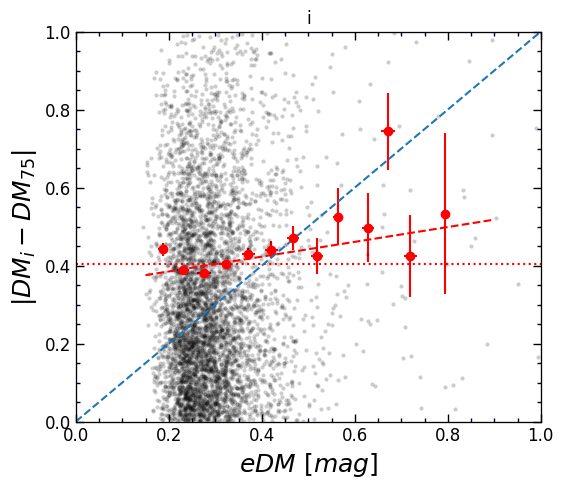

In [28]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = eDM_fid
Y = np.abs(DMav_fid - dff.DM_75.values)

V3k = dff.V3k.values
X = X[V3k>4000]
Y = Y[V3k>4000]

ax.plot(X, Y, 'k.', alpha=0.2, mfc='k', mec='none')

X = X[Y<1]
Y = Y[Y<1]

factor = np.sqrt(np.pi/2.)
for i in np.arange(0.15,0.8,0.05):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.05:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        xp = np.asarray(xp)
        yp = np.asarray(yp)
        yp *= factor
        ax.errorbar(np.median(xp), np.mean(yp), yerr=np.std(yp)/np.sqrt(len(yp)), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
        
ax.set_ylabel(r'$|DM_{i} - DM_{75}|$', fontsize=18)
ax.set_xlabel(r'$eDM \/\/ [mag]$', fontsize=18)

# ax.plot([0,1], [0,0], ':', color='k')

set_axes(ax, (0,1), (0,1), fontsize=12)

ax.set_title("i")

from ltsfit.lts_linefit import lts_linefit
mcfit = lts_linefit(X, factor*Y, X*0+0.001, Y*0+0.001, clip=3., plot=False)
xx = np.linspace(0.15,0.9,100)
ax.plot(xx, mcfit.ab[1]*xx+mcfit.ab[0], '--', color='red')

yy0 = np.mean(factor*Y)
ax.plot([0,1],[yy0,yy0], ':', color='red')
ax.plot([0,1],[0,1], '--', color='#1f77b4')

In [29]:
mcfit.ab

array([0.34702629, 0.18975218])

<ipython-input-30-769f9d187063>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['dDM'] = DM_fid - dff.DM_75.values
<ipython-input-30-769f9d187063>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['DMriz_fid'] = DM_fid
<ipython-input-30-769f9d187063>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

Text(0.5, 1.0, '<riz>')

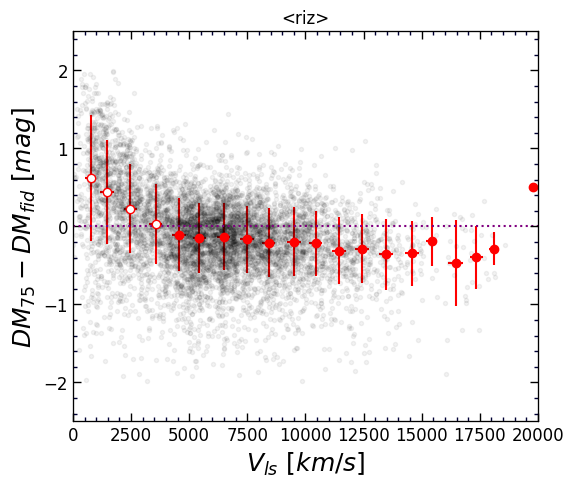

In [30]:
dff['dDM'] = DM_fid - dff.DM_75.values
dff['DMriz_fid'] = DM_fid
dff['DMav_i'] = DMav_fid
dff['eDM_i'] = eDM_fid
eDM_adj = mcfit.ab[1]*eDM_fid+mcfit.ab[0]
for jj in range(len(eDM_fid)):
    if eDM_fid[jj]>eDM_adj[jj]:
        eDM_adj[jj]=eDM_fid[jj]
dff['eDM_i_adj'] = eDM_adj

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X = dff.V3k.values
Y = dff.dDM.values
# logW = dff.lgWmxi.values

X = X[np.abs(Y)<2]
Y = Y[np.abs(Y)<2]

ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(4000,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   


for i in np.arange(0,4000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6, mfc='white')   
        
        
ax.set_xlabel(r'$V_{ls} \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$DM_{75} - DM_{fid}\/\/[mag]$', fontsize=18)
# ax.set_ylabel(r'$log \/ (D_{75}/D_{fid})$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='purple')

set_axes(ax, (0,20000), (-2.5,2.5), fontsize=12)

ax.set_title("<riz>")

In [31]:
np.mean(Y[X>4000])

-0.21432586628783187

Text(0.5, 1.0, 'i')

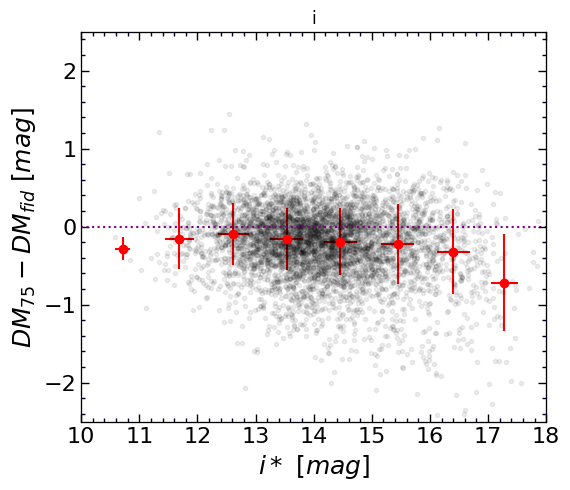

In [32]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


dff_ = dff[dff.V3k>4000]

X = dff_['i***'].values
Y = dff_.dDM.values
V = dff_.V3k.values

ax.plot(X, Y, 'k.', alpha=0.07)

X = X[np.abs(Y)<2]
Y = Y[np.abs(Y)<2]

for i in np.arange(10,18,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1 and ~np.isnan(xi) and ~np.isnan(Y[ii]):
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$i* \/\/[mag]$', fontsize=18) 
ax.set_ylabel(r'$DM_{75} - DM_{fid}\/\/[mag]$', fontsize=18)
# ax.set_ylabel(r'$log \/ (D_{75}/D_{fid})$', fontsize=18)


ax.plot([10,18], [0,0], ':', color='purple')

set_axes(ax, (10,18), (-2.5,2.5))

ax.set_title("i")

In [33]:
dff['Mass_HI'] = 2.356E5 * dff.F21 * (dff.D75**2)   # D75
try:
    dff['Mb'] = dff.Ms_riz + 1.33*(10**(np.log10(dff.Mass_HI)))
except:
    dff['Mb'] = dff.Ms_i + 1.33*(10**(np.log10(dff.Mass_HI)))
    
dff['logMb'] = np.log10(dff.Mb.values)

dff = dff.rename(columns={'DMriz_fid':'DMi_fid'})
try:
    dff = dff.rename(columns={'Ms_riz':'Ms_i'})
except:
    pass

dff[['DM_75', 'DMi_fid', 'Mass_HI', 'Ms_i', 'Mb', 'F21', 'eF21', 'Qs', 'DMav_i', 'eDM_i', 'eDM_i_adj']].to_csv("MLratio_i_distances_noCorrection.csv")

<ipython-input-33-f434cd44210c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['Mass_HI'] = 2.356E5 * dff.F21 * (dff.D75**2)   # D75
/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-33-f434cd44210c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['Mb'] = dff.Ms_riz + 1.33*(10**(np.log10(dff.Mass_HI)))
<ipython-input-33-f434cd44210c>:7: SettingWithCopy

In [34]:
dff.columns

Index(['flag', 'DM_av', 'eDM', 'DM_riz', 'eDM_riz', 'DM_W1', 'eDM_W1', 'DM_75',
       '1PGC', 'Nest', 'logMs_riz', 'logMs_W1', 'logM_gas', 'logMb', 'Vhel',
       'V3k', 'v3k', 'f', 'lgWmxi', 'elgWi', 'F21', 'eF21', 'inc', 'einc',
       'g***', 'r***', 'i***', 'z***', 'w1***', 'Qs', 'Qw', 'RA', 'DE',
       'GLong', 'GLat', 'SGL', 'SGB', 'Nkt', 'N15', 'SGLg', 'SGBg', 'Vhg',
       'Vlsg', 'V3kg', 'fg', 'Vmod', 'D75', 'logD75', 'Mg_75', 'Mr_75',
       'Mi_75', 'Mz_75', 'M1_75', 'gi', 'F', 'e_F', 'Flux', 'F21_av', 'Ms_W1',
       'Mass_HI', 'logMs_i', 'logMs_r', 'logMs_z', 'Ms_i', 'Mb', 'dDM',
       'DMi_fid', 'DMav_i', 'eDM_i', 'eDM_i_adj'],
      dtype='object')

(3.141549843952685, 10.429458857354692)

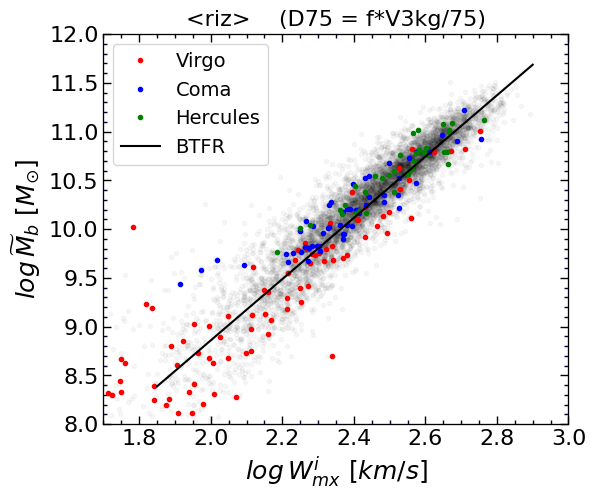

In [35]:
dff['Mass_HI'] = 2.356E5 * dff.F21 * (dff.D75**2)   # D75
dff['Mb'] = dff.Ms_i + 1.33*(10**(np.log10(dff.Mass_HI)+HI_corrector(mc, 0, dff.V3k.values)))
dff['logMb'] = np.log10(dff.Mb.values)

######################################################################
dff = dff.rename(columns={"1PGC": "PGC1"})

df_vrigo = dff[dff.PGC1==41220]
df_coma = dff[dff.PGC1==44715]
df_herc = dff[dff.PGC1==56962]

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values


fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

plt.plot(logW, logMass, '.', color='black', alpha=0.03) 


ax.plot(df_vrigo.lgWmxi, df_vrigo.logMb, 'r.', label='Virgo')
ax.plot(df_coma.lgWmxi, df_coma.logMb, 'b.', label='Coma')
ax.plot(df_herc.lgWmxi, df_herc.logMb, 'g.', label='Hercules')

ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ \widetilde{M}_b \/\/ [M_{\odot}]$', fontsize=18)

set_axes(ax, (1.7,3), (8,12))
ax.set_title("<riz>    (D75 = f*V3kg/75)", fontsize=16)

w = np.linspace(1.85,2.9,100)
ax.plot(w, m0*(w-2.5) + zp_calib, 'k-', label='BTFR')

ax.legend(fontsize=14, loc=2)   

m0, b0

In [36]:
len(dff)

7096